# Imports

In [2]:
""" For future reference : if cortex is complaining about a bad path for fsaverage etc, go into ~/.config/pycortex/options.cfg 
and give the full /home/<user>/pycortex/filestore/db path"""
import os
print("CWD: ", os.getcwd())
import cortex
# cortex.download_subject('fsaverage')
print(cortex.options.usercfg)
file_store = cortex.options.config.get('basic', 'filestore')
print(file_store)
file_path = os.path.join(file_store, 'fsaverage', 'overlays.svg')
print(file_path)
print(cortex.options.config.get('webgl', 'colormaps'))
# cortex.webshow(cortex.Volume.random("S1", "fullhead"))

CWD:  /home/hpcgies1/Masters-Thesis/AttemptFour/notebooks
/home/hpcgies1/.config/pycortex/options.cfg
/home/hpcgies1/pycortex/filestore/db/
/home/hpcgies1/pycortex/filestore/db/fsaverage/overlays.svg
/home/hpcgies1/pycortex/filestore/colormaps/


In [55]:
import numpy as np
import glob
import pylab
import pandas as pd
import time
import nibabel as nb
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json

# Load data

In [17]:
model_name = 'subject_2_baseline2'
home_dir = f'/home/hpcgies1/Masters-Thesis/AttemptFour/'
eval_dir = '/home/hpcgies1/Masters-Thesis/AttemptFour/Log/'
data_dir = f'/home/hpcgies1/Masters-Thesis/AttemptFour/Log/{model_name}/eval_out'
print(os.listdir(data_dir))

['tokenizer.json', 'output_captions_80.npy', 'output_captions_raw_80.npy', 'attention_scores_80.npy', 'output_guse.npy']


In [4]:
"""
Load Glasser data
"""

GLASSER_LH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/lh.HCP_MMP1.mgz"
GLASSER_RH = "/rds/user/hpcgies1/hpc-work/NIC/NSD/nsddata/freesurfer/fsaverage/label/rh.HCP_MMP1.mgz"
s = time.time()
glasser_lh = nb.load(GLASSER_LH).get_fdata() # 163_842 values in the range [0, 180]
glasser_rh = nb.load(GLASSER_RH).get_fdata()
print(f"load glasser masks: {(time.time() - s):.2f}")

glasser = np.vstack((glasser_lh, glasser_rh)).flatten()

print("glasser_lh", glasser_lh.shape)
print("glasser_rh", glasser_rh.shape)
print("glasser   ", glasser.shape)

glasser_lh_flat = glasser_lh.flatten()
glasser_rh_flat = glasser_rh.flatten()
glasser_indices_rh = np.array(range(len(glasser_rh_flat)))
groups_rh = []
for i in set(glasser_rh_flat):
    groups_rh.append(glasser_indices_rh[glasser_rh_flat == i])
glasser_indices_lh = np.array(range(len(glasser_lh_flat)))
groups_lh = []
for i in set(glasser_rh_flat):
    groups_lh.append(glasser_indices_lh[glasser_lh_flat == i])
groups = groups_lh[1:] + groups_rh[1:]
#groups_concat = list(map(list.__add__, groups_lh, groups_rh))
groups_lh = groups_lh[1:]
groups_rh = groups_rh[1:]
assert len(groups) == 360, "Using separate hemishere groups = 360"


load glasser masks: 0.16
glasser_lh (163842, 1, 1)
glasser_rh (163842, 1, 1)
glasser    (327684,)


In [5]:
def load_data(fname):
    with open(fname, "rb") as f:
        data = np.load(f)
    return np.squeeze(data, axis=-1)

def rank_transform(data):
    return np.log(data)

def get_flatmap(glasser_regions):
    cortex.add_roi
    vert = cortex.Vertex(glasser_regions, subject='fsaverage')#, vmin=-8, vmax=8)
    im, extents = cortex.quickflat.make_flatmap_image(vert)
    return im, extents

In [6]:

def generate_plot(data_):
    """ Generate the glasser_regions which can be converted to flatmap and plotted 
    Parameters
    ----------
        data : np.array - 1-D  (360,)
    """
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    glasser_regions_lh[:] = np.NaN
    glasser_regions_rh[:] = np.NaN
    for i, g in enumerate(groups_lh):
        glasser_regions_lh[g] = data_[i]
    for i, g in enumerate(groups_rh):
        glasser_regions_rh[g] = data_[i+180]
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)
    return glasser_regions

def plot_attention(data_, **kwargs):
    """ 
    Parameters
    ----------
        data_ : 1-d data (360,)
    """
    title = kwargs.get('title')
    
    fig, axes = plt.subplots(1, 1, figsize=(16,6))
    fig.tight_layout()#rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f"{title}")

    # Sub 1
    glasser_regions = generate_plot(data_)

    im, _ = get_flatmap(glasser_regions)
    axes.imshow(im, cmap=plt.get_cmap('viridis'))
    axes.set_title(f"subject 2")
    axes.axis('off')
    plt.show()

# plot_attention()

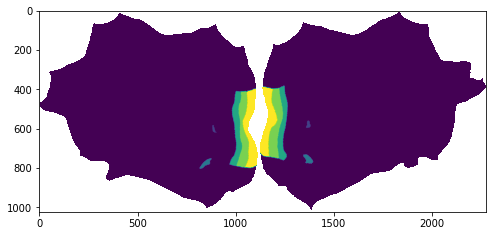

In [13]:
def plot_region(region_names: list = ['FFA']):
    NUM_COLORS = len(region_names)
    cm = pylab.get_cmap('viridis')
    
    # Get region indices in fsaverage space
    roi_verts = cortex.get_roi_verts('fsaverage', region_names)
    
    fig, ax = plt.subplots(figsize=(16,9))
    glasser_regions_lh = np.zeros(glasser_lh.shape)
    glasser_regions_rh = np.zeros(glasser_rh.shape)
    
    idx = 0
    c = 1
    for k, v in roi_verts.items():
        for i in v:
            if i >= 163842:
                i -= 163842
                glasser_regions_rh[i] = c
            else:
                glasser_regions_lh[i] = c
        idx += 1
        c -= 1/NUM_COLORS
            
    glasser_regions = np.vstack((glasser_regions_lh, glasser_regions_rh)).flatten() # (327684,)

    im, _ = get_flatmap(glasser_regions)
    plt.imshow(im, cmap=plt.get_cmap('viridis'))
    plt.title(f"Regins of interest: {' '.join(region_names)}")
    plt.show()
# plot_region(['V1', 'V2', 'V3', 'FFA', 'MST'])

def plot_region(region_names: list, space = 'fsaverage'):
    roi_verts = cortex.get_roi_verts(space, region_names)

    ffa_map = cortex.Vertex.empty(space, cmap='plasma')
    c = 1.0
    for i in region_names:
        verts = roi_verts[i]
        ffa_map.data[verts] = c
        c -= 1/len(region_names)

    im, extents = cortex.quickflat.make_flatmap_image(ffa_map)
    plt.figure(figsize=(8,4))
    plt.imshow(im)
    plt.show()
 
ls = ['V1', 'V2', 'V3', 'FFA', 'MST']
# ls = ['PPA', 'FFA', 'OFA', 'SPL1', 'IPS5', 'IPS4', 'IPS3', 'IPS2', 'IPS1', 'IPS0', 'VO2', 'VO1', 'MST', 'hMT', 'LO2', 'LO1', 'V4', 'V3B', 'V3A', 'V3', 'V2', 'V1']
plot_region(ls, 'fsaverage')

In [9]:
# print(cortex.db.fsaverage.surfaces)
# cortex.db.fsaverage.surfaces.inflated.show()

# Plot attention maps


---

In [18]:
models = os.listdir(eval_dir)
print(models)

['subject_1_baseline', 'subject_1_layer_norm', 'subject_2_baseline2', 'all_subjects', 'test_ms3', 'subject_2_attn_layer_norm', 'subject_2_dense_layer_norm', 'subject_1_and_2', 'all_subjects_3', 'subs_1_2_5_7', 'subject_2_lstm_layer_norm', 'subject_2_attn_loss', 'subject_2_layer_norm', 'subject_2_both_layer_norm', 'all_subjects_2', 'all_subjects_naive', 'subject_2_noise']


In [19]:
data = {}
for i, m in enumerate(models):
    p = glob.glob(f"{eval_dir}/{m}/eval_out/attention_scores_*")
    if p != []:
        data[m] = load_data(p[0])

for k,v in data.items():
    print(k, len(v))

subject_2_baseline2 515
all_subjects 4120
subject_2_attn_layer_norm 515
subject_2_dense_layer_norm 515
subject_1_and_2 2
subject_2_lstm_layer_norm 515
subject_2_layer_norm 515
subject_2_both_layer_norm 515


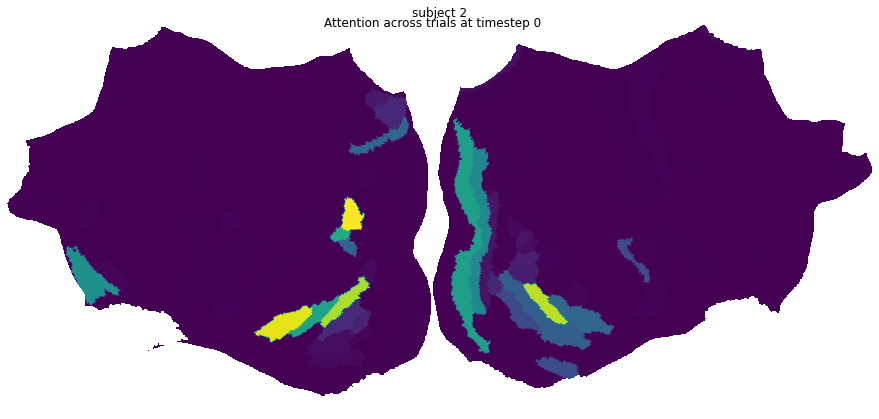

In [12]:
plot_attention(np.mean(data['subject_2_attn_layer_norm'], axis=(0,1)), title='Attention across trials at timestep 0')

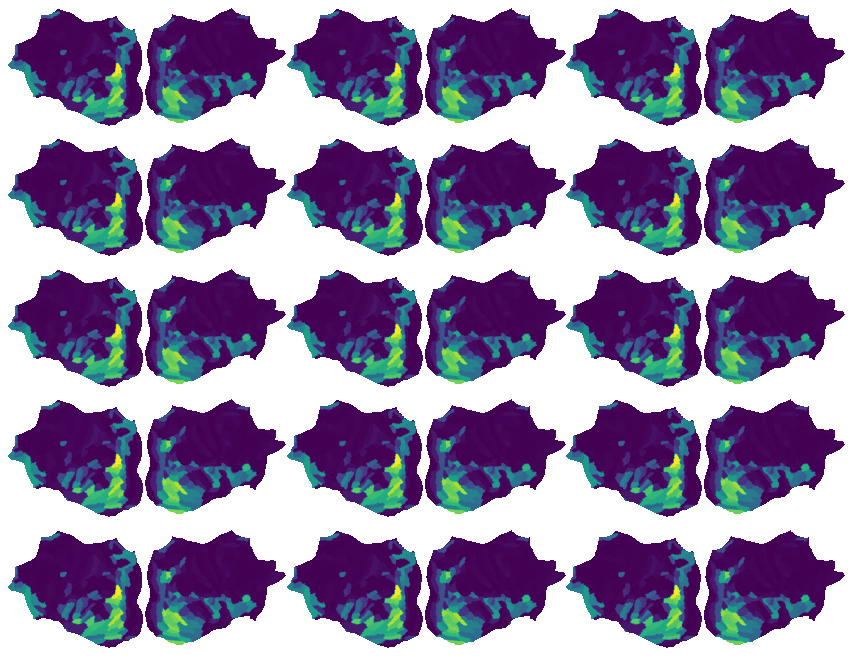

In [13]:
## Plot attention maps across timesteps

do_rank_transform = False
if do_rank_transform:
    data_time = rank_transform(np.mean(data['subject_2_both_layer_norm'], axis=0))
else:
    data_time = np.mean(data['subject_2_both_layer_norm'], axis=0)

fig, ax = plt.subplots(5, 3, figsize=(15,12))

rr, cc = 0, 0
for i in range(15):
    d = data_time[i, :]
    gr = generate_plot(d)
    im, _ = get_flatmap(gr)
    
    ax[rr, cc].imshow(im)
    ax[rr,cc].axis('off')
    rr += 1
    if rr >= 5:
        rr = 0
        cc += 1

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

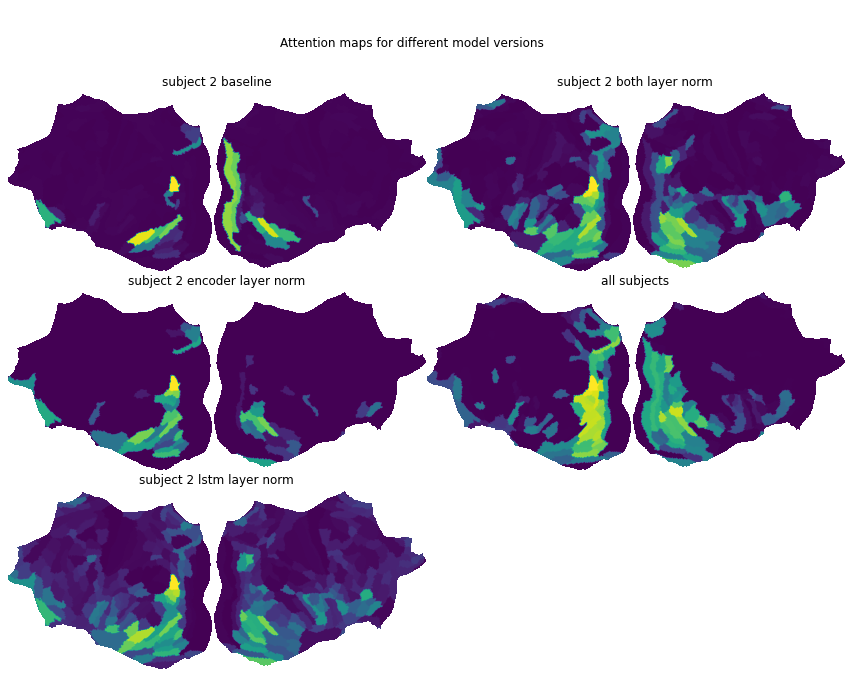

' We see strong activation in broadman area 47 (OFC left-hemi)'

In [29]:
# print(data.keys())
fig, ax = plt.subplots(3, 2, figsize=(15, 11))

interests = ['subject_2_baseline2', 
             'subject_2_dense_layer_norm', 
             'subject_2_lstm_layer_norm',
             'subject_2_both_layer_norm', 
             'all_subjects', 
             ]
names = ['subject 2 baseline',
         'subject 2 encoder layer norm',
         'subject 2 lstm layer norm',
         'subject 2 both layer norm',
         'all subjects']

i = 0
r, c = 0, 0
# for k, v in data.items():
for i, k in enumerate(interests):
    v = data[k]
    d = np.mean(v, axis=(0,1))
    try:
        gr = generate_plot(d)
    except Exception:
        continue
    im, _ = get_flatmap(gr)
    
    ax[r,c].imshow(im)
    ax[r,c].axis('off')
    ax[r,c].set_title(names[i])
    r += 1
    if r >= 3:
        r = 0
        c += 1

ax[r,c].axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle("\n\nAttention maps for different model versions")
# plt.savefig(f"{home_dir}/Plots/different_attn_maps.png", bbox_inches='tight')
plt.show()

""" We see strong activation in broadman area 47 (OFC left-hemi)"""



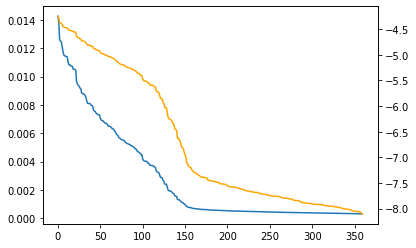

In [36]:
temp = np.mean(data['subject_2_both_layer_norm'], axis=(0,1))
temp_idx = np.argsort(temp)[::-1]
fig, ax = plt.subplots(1,1)
ax.plot(temp[temp_idx])
ax2=ax.twinx()
ax2.plot(np.log(temp[temp_idx]),color='orange')

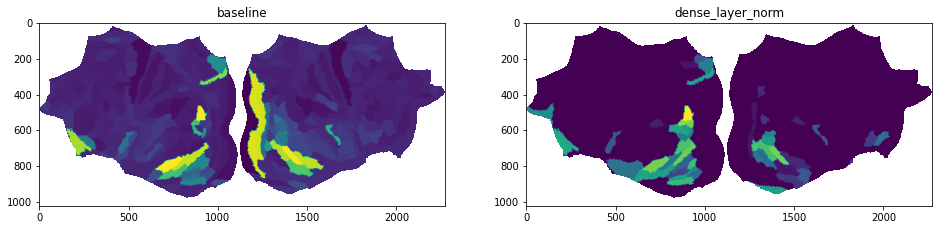

In [342]:
x1 = rank_transform(data['subject_2_baseline2'])
x2 = data['subject_2_dense_layer_norm']

fig, ax = plt.subplots(1, 2, figsize=(16,9))
d = np.mean(x1, axis=(0,1))
im, _ = get_flatmap(generate_plot(d))
ax[0].imshow(im)
ax[0].set_title("baseline")

d = np.mean(x2, axis=(0,1))
im, _ = get_flatmap(generate_plot(d))
ax[1].imshow(im)
ax[1].set_title("dense_layer_norm")

plt.show()

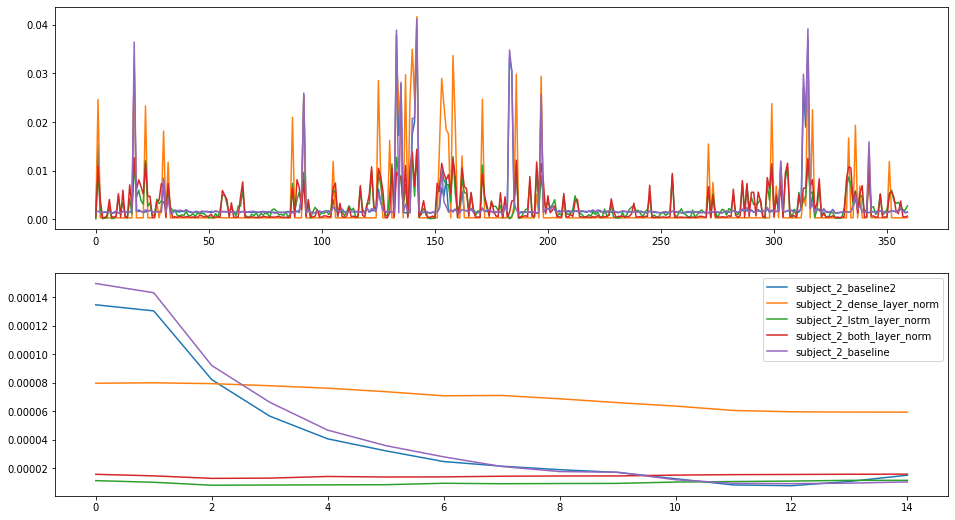

In [336]:
# Plot variance

fig, ax = plt.subplots(2, 1, figsize=(16, 9))

i = 0
for i, (k, v) in enumerate(data.items()):
    d = np.mean(v, axis=(0,1))
    ax[0].plot(d, label=k)
    
i = 0
for i, (k, v) in enumerate(data.items()):
    y = []
    for i in range(15):
        y.append( np.var(v[i,:,:], axis=1) )
    y = np.array(y)
    
    y_mean = np.mean(y, axis=0)
    
    ax[1].plot(y_mean, label=k) 
    
    
plt.legend()
plt.show()



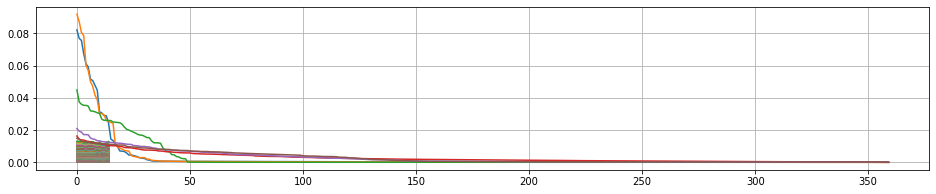

In [309]:
plt.figure(figsize=(16,3))

for i, (k, v) in enumerate(data.items()):
    d = np.sort(np.mean(v, axis=0)[0])[::-1]
    plt.plot(d, label=k)

plt.grid()
# plt.legend()
plt.show()

## Variance at word position

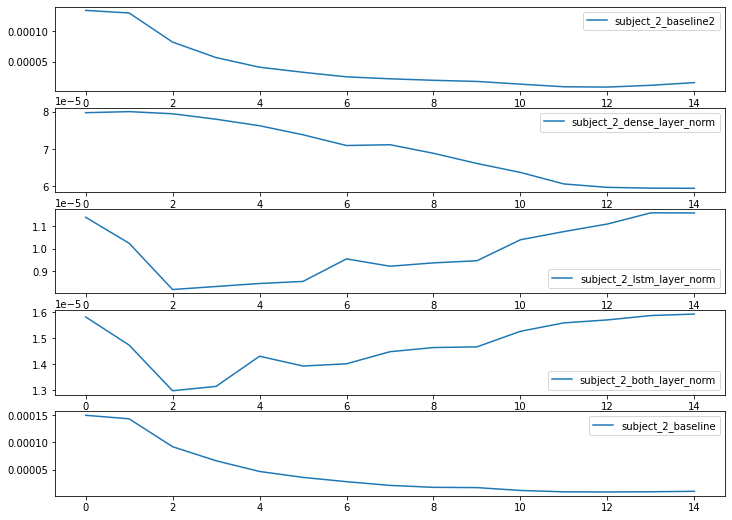

In [338]:
fig, ax = plt.subplots(5,1,figsize=(12,9))

i = 0
r = 0
for i, (k, v) in enumerate(data.items()):
    y = []
    for j in range(15):
        y.append( np.var(v[j,:,:], axis=1) )
    y = np.array(y)
    
    y_mean = np.mean(y, axis=0)
    
#     for j in range(y.shape[0]):
#         ax[i].plot(y[j], color='darkgray')
    ax[i].plot(y_mean, label=k) 

    ax[i].legend()
    
plt.show()  

---

# All subjects

---

    single encoder 
    layer norm dense and lstm

In [18]:
model = 'all_subjects'
epoch = 71
# model = 'subject_2_baseline2'
# epoch = 80
# model = 'subject_2_both_layer_norm'
# epoch = 25
home_dir = f'/home/hpcgies1/Masters-Thesis/AttemptFour/'
model_path = f'/home/hpcgies1/Masters-Thesis/AttemptFour/Log/{model}/eval_out/attention_scores_{epoch}.npy'

In [19]:
X = load_data(model_path)
X.shape

(4120, 15, 360)

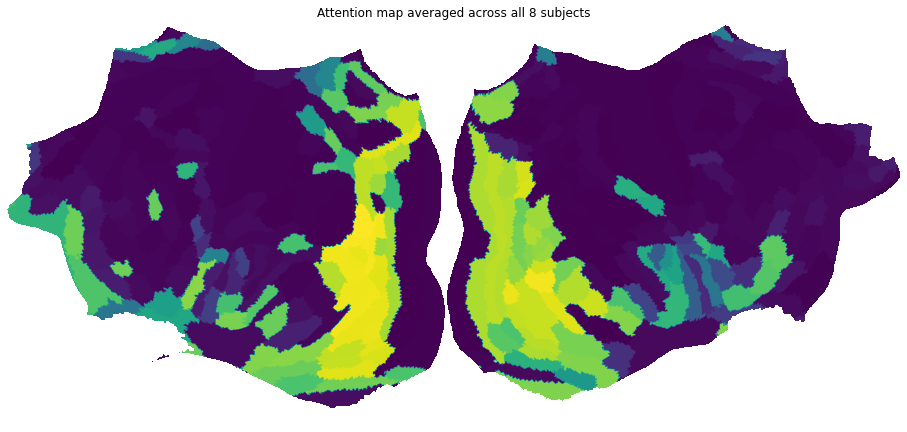

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))

d = np.log(np.mean(X, axis=(0,1)))

im, _ = get_flatmap(generate_plot(d))
ax.imshow(im)

ax.axis('off')

plt.title("Attention map averaged across all 8 subjects")
plt.show()

In [21]:
X_split = np.zeros((8, 515, 15, 360))
for i in range(8):
    X_split[i, :, :, :] = X[515*i:515*i+515]

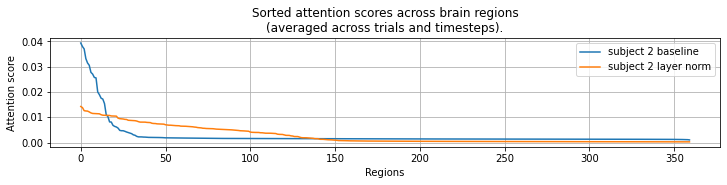

In [22]:
X_sub2 = np.mean(load_data(f"{home_dir}/Log/subject_2_both_layer_norm/eval_out/attention_scores_25.npy"), axis=(0,1))
xx2 = np.argsort(X_sub2)[::-1]

X_sub2_b = np.mean(load_data(f"{home_dir}/Log/subject_2_baseline2/eval_out/attention_scores_80.npy"), axis=(0,1))
xx2b = np.argsort(X_sub2_b)[::-1]

xx = np.argsort(np.mean(X, axis=(0,1)))[::-1]

fig, ax = plt.subplots(1,1,figsize=(12,2))
# ax.plot(np.mean(X, axis=(0,1))[xx], label='all subjects')
ax.plot(X_sub2_b[xx2b], label='subject 2 baseline')
ax.plot(X_sub2[xx2], label='subject 2 layer norm')
plt.title(f"Sorted attention scores across brain regions\n(averaged across trials and timesteps).")
plt.ylabel(f'Attention score')
plt.xlabel(f"Regions")
plt.grid()
plt.legend()
# plt.savefig(f"{home_dir}/Plots/attn_scores_across_regions.png", bbox_inches='tight')
plt.show()


## Twinx plot
# fig, ax = plt.subplots(1,1,figsize=(12,2))
# plt.grid()

# ax.plot(np.mean(X, axis=(0,1))[xx], label='all subjects')
# ax2 = ax.twinx()
# ax2.plot(X_sub2[xx2], c = 'orange', label='subject 2')

# ax.set_ylabel('Attention score', color='blue')
# ax2.set_ylabel('Attention score', color='orange')
# fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
# plt.show()

(360,)


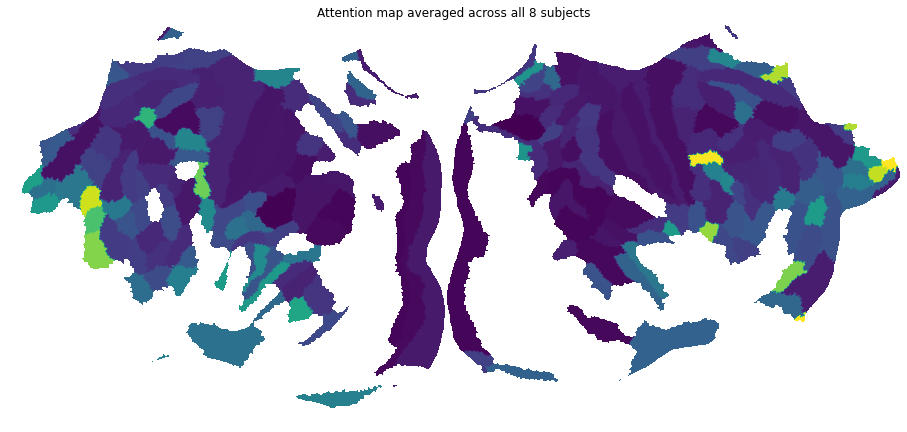

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))

mod = np.mean(X, axis=(0,1))
mod[xx[:150]] = np.NaN
print(mod.shape)

im, _ = get_flatmap(generate_plot(mod))
ax.imshow(im)

ax.axis('off')

plt.title("Attention map averaged across all 8 subjects")
plt.show()

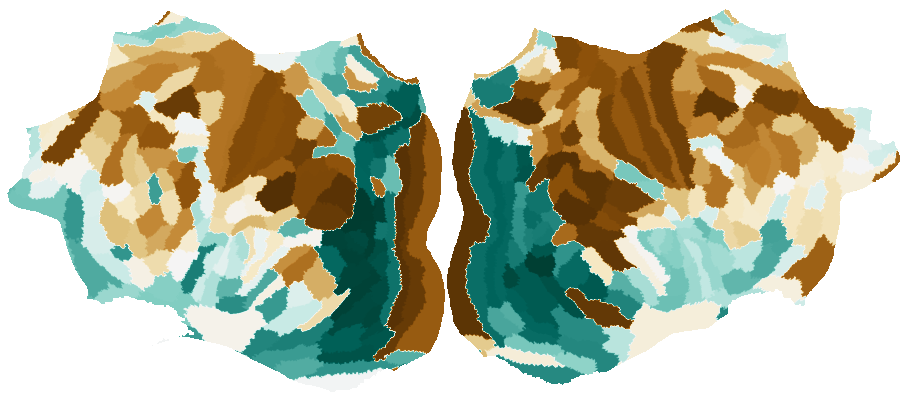

In [24]:
def rank_transform(x, a):
    return 1 - 1/(a+x)

fig, ax = plt.subplots(1, 1, figsize=(16,9))
d = np.mean(X, axis=(0,1))
ds = np.argsort(d)#[::-1]
d[ds] = np.linspace(0, 1, 360)
im, _ = get_flatmap(generate_plot(d))
ax.imshow(im, cmap='BrBG') # BrBG
ax.axis('off')
# plt.savefig(f"{home_dir}/Plots/8_subs_mean_title_img_inferno.png", bbox_inches='tight')
plt.show()

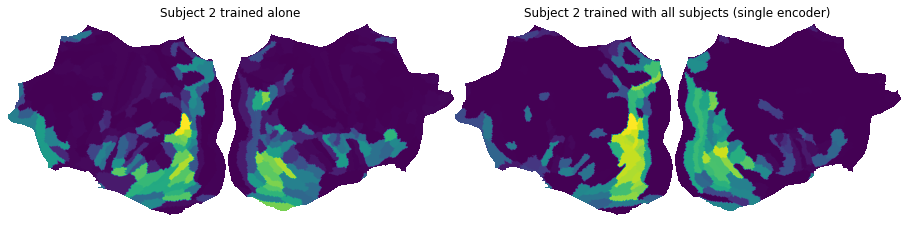

In [25]:

X_sub2 = load_data(f"{home_dir}/Log/subject_2_both_layer_norm/eval_out/attention_scores_25.npy")


fig, ax = plt.subplots(1, 2, figsize=(16,12))

ax[0].imshow(get_flatmap(generate_plot(np.mean(X_sub2, axis=(0,1))))[0])
ax[1].imshow(get_flatmap(generate_plot(np.mean(X[0:515], axis=(0,1))))[0])

ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title("Subject 2 trained alone")
ax[1].set_title("Subject 2 trained with all subjects (single encoder)")

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"{home_dir}/Plots/sub2_alone_vs_sub2_all.png", bbox_inches='tight')
plt.show()

In [220]:
from scipy import linalg
from numpy.random import default_rng
import time

Xt = np.mean(X, axis=1)

start = time.time()
U, s, Vh = linalg.svd(Xt)
print(f"{(time.time() - start):.3f}")

2.009


In [66]:
df_regions = pd.read_csv("~/Masters-Thesis/AttemptFour/TrainData/unique_regions_list.csv")
# print(df_regions.head(2))
def idx_to_region(idx: int):
    """
    idx: int [0, 360)
    """
    return df_regions.iloc[idx].regionLongName, df_regions.iloc[idx].regionName

  regionName                   regionLongName regionIdLabel LR region Lobe  \
0       V1_L          Primary_Visual_Cortex_L           1_L  L     V1  Occ   
1      MST_L  Medial_Superior_Temporal_Area_L           2_L  L    MST  Occ   

                                     cortex  regionID  Cortex_ID       x-cog  \
0                            Primary_Visual         1          1  100.491589   
1  MT+_Complex_and_Neighboring_Visual_Areas         2          5  132.416667   

       y-cog      z-cog  volmm  
0  41.138901  71.637040   6717  
1  58.901786  82.059524    336  


In [179]:
print(U.shape)
print(s.shape)
print(Vh.shape)

var_explained = np.round(s**2/np.sum(s**2), decimals=3)
print(var_explained[:10])

num_components = 1
reconst_img = np.matrix(U[:, [num_components]]) * np.diag(s[[num_components]]) * np.matrix(Vh[[num_components], :])
reconst_img = np.array(reconst_img)
print(reconst_img.shape)


(4120, 4120)
(360,)
(360, 360)
[0.991 0.001 0.001 0.001 0.    0.    0.    0.    0.    0.   ]
(4120, 360)


max 20 Area_Lateral_Occipital_2_L
min 183 Second_Visual_Area_R


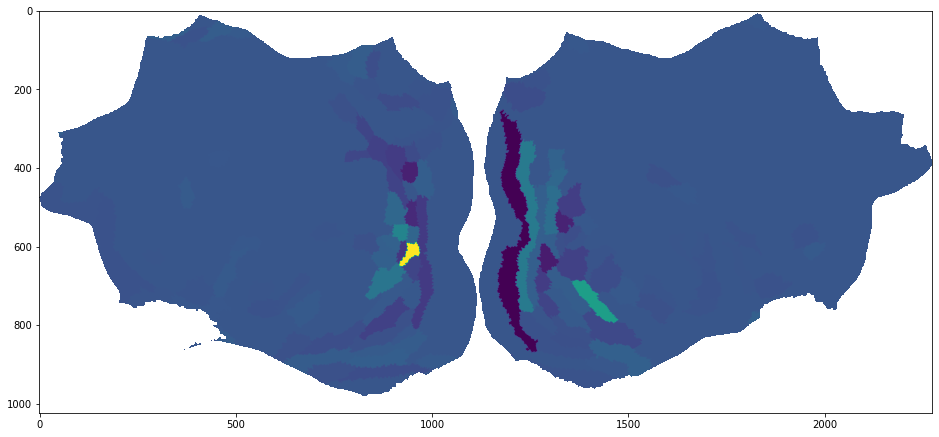

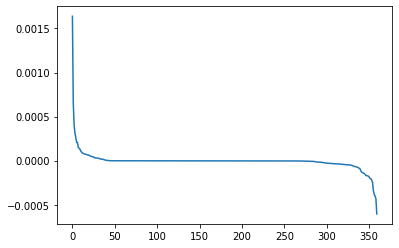

In [180]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))

plt.imshow(get_flatmap(generate_plot(reconst_img[0]))[0], cmap='viridis')


max_ = np.argmax(reconst_img[0])
min_ = np.argmin(reconst_img[0])
print("max", max_, idx_to_region(max_)[0])
print("min", min_, idx_to_region(min_)[0])



plt.show()


xx = np.argsort(reconst_img[0])[::-1]
plt.plot(reconst_img[0][xx])
plt.show()


In [39]:
X = load_data(f"{home_dir}/Log/subject_2_baseline2/eval_out/attention_scores_80.npy")
X = np.mean(X, axis=(0,1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 180/180 [1:09:33<00:00, 23.19s/it]


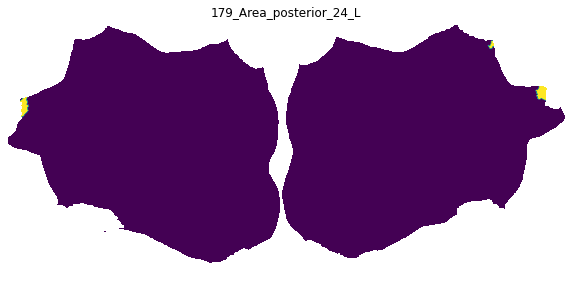

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
for i in tqdm.tqdm(range(180)):
    temp = np.zeros_like(X)
    temp[i] = 1
    temp[i+180] = 1
    ax.imshow(get_flatmap(generate_plot(temp))[0], cmap='viridis')
    ax.axis('off')
    r = idx_to_region(i)[0]
    ax.set_title(f"{i}_{r}")
    plt.savefig(f"{home_dir}/Plots/Regions/{i:03}_{r}.jpeg", bbox_inches='tight')
plt.show()

0    Primary_Visual_Cortex_L
Name: regionLongName, dtype: object


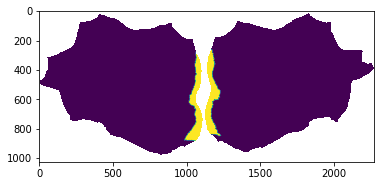

In [90]:

# Dorsal_Transitional_Visual_Area_R - 321
# Temporo-parieto-occipital-junction - 318, 319, 320

roi = np.array([142])
roi2 = roi - 180
temp = np.zeros_like(X)
temp[roi] = 1
temp[roi2] = 1
print(idx_to_region(roi)[0])
plt.imshow(get_flatmap(generate_plot(temp))[0], cmap='viridis')
plt.show()